<a href="https://colab.research.google.com/github/Int-Group-44/flowers-102/blob/main/OxfordFlowers102CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
#device_name = tf.test.gpu_device_name()
#if device_name != '/device:GPU:0':
#  raise SystemError('GPU device not found')
#print('Found GPU at: {}'.format(device_name))

dataset, dataset_info = tfds.load('oxford_flowers102', with_info=True, as_supervised=True)
dataset_info
test_set, training_set, validation_set = dataset['test'], dataset['train'], dataset['validation']

In [16]:
import tensorflow as tf
tf.config.experimental.list_physical_devices('GPU')
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    print(e)

print(gpus)

Physical devices cannot be modified after being initialized
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Importing TensorFlow 

In [17]:
num_classes = dataset_info.features['label'].num_classes
num_training_examples = 1020
num_validation_examples = 1020

In [18]:
IMAGE_RES = 224

def format_image(image, label):
    image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
    #label = tf.one_hot(label, depth=num_classes)
    return image, label
BATCH_SIZE = 16
train_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_set.shuffle(num_validation_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
test_batches = test_set.map(format_image).batch(BATCH_SIZE).prefetch(1)


In [19]:
def make_model(input_shape, num_classes):
  model = tf.keras.Sequential()
  model.add(layers.RandomFlip("horizontal_and_vertical", input_shape=input_shape))
  model.add(layers.RandomRotation(20))
  model.add(layers.RandomZoom(0.2))
  model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D())
  model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D())
  model.add(layers.Conv2D(128, 3, padding='same', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(128, 3, padding='same', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D())
  model.add(layers.Conv2D(256, 3, padding='same', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(256, 3, padding='same', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D())
  model.add(layers.Conv2D(512, 3, padding='same', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(512, 3, padding='same', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D())
  model.add(layers.Flatten())
  model.add(layers.Dense(1024, activation='relu'))
  model.add(layers.Dropout(0.35))
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dropout(0.35))
  model.add(layers.Dense(256, activation='relu'))
  model.add(layers.Dropout(0.35))
  model.add(layers.Dense(num_classes))
  return model


In [20]:
tf.keras.backend.clear_session()
model = make_model(input_shape=(IMAGE_RES, IMAGE_RES) + (3,), num_classes=102)

In [21]:

#keras.utils.plot_model(model, show_shapes=True)

epochs = 150

#reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.000075),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

history = model.fit(
    train_batches,
    epochs=epochs,
    validation_data=validation_batches,
    batch_size=BATCH_SIZE,
    validation_batch_size=BATCH_SIZE,
    verbose=1
    #callbacks=[reduce_lr]
)

Epoch 1/150
64/64 [==============================] - 19s 157ms/step - loss: 5.6842 - accuracy: 0.0069 - val_loss: 4.7294 - val_accuracy: 0.0127
Epoch 2/150
64/64 [==============================] - 10s 154ms/step - loss: 4.8791 - accuracy: 0.0196 - val_loss: 4.7277 - val_accuracy: 0.0147
Epoch 3/150
64/64 [==============================] - 10s 150ms/step - loss: 4.7387 - accuracy: 0.0118 - val_loss: 4.6985 - val_accuracy: 0.0088
Epoch 4/150
64/64 [==============================] - 10s 155ms/step - loss: 4.7172 - accuracy: 0.0167 - val_loss: 4.6727 - val_accuracy: 0.0127
Epoch 5/150
64/64 [==============================] - 13s 192ms/step - loss: 4.6466 - accuracy: 0.0108 - val_loss: 4.6297 - val_accuracy: 0.0167
Epoch 6/150
64/64 [==============================] - 11s 157ms/step - loss: 4.6234 - accuracy: 0.0167 - val_loss: 4.5942 - val_accuracy: 0.0245
Epoch 7/150
64/64 [==============================] - 10s 152ms/step - loss: 4.5946 - accuracy: 0.0206 - val_loss: 4.5379 - val_accuracy:

In [22]:
tloss1 = history.history['loss']
vloss1 = history.history['val_loss']
tacc1 = history.history['accuracy']
vacc1 = history.history['val_accuracy']

In [23]:

#keras.shutils.plot_model(model, ow_shapes=True)

epochs = 150

#reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

history = model.fit(
    train_batches,
    epochs=epochs,
    validation_data=validation_batches,
    batch_size=BATCH_SIZE,
    validation_batch_size=BATCH_SIZE,
    verbose=1
    #callbacks=[reduce_lr]
)

Epoch 1/150
64/64 [==============================] - 19s 157ms/step - loss: 0.9092 - accuracy: 0.7314 - val_loss: 3.0476 - val_accuracy: 0.4588
Epoch 2/150
64/64 [==============================] - 13s 191ms/step - loss: 0.8656 - accuracy: 0.7471 - val_loss: 2.7502 - val_accuracy: 0.4902
Epoch 3/150
64/64 [==============================] - 13s 194ms/step - loss: 0.8527 - accuracy: 0.7480 - val_loss: 2.9280 - val_accuracy: 0.4667
Epoch 4/150
64/64 [==============================] - 11s 161ms/step - loss: 0.9568 - accuracy: 0.7196 - val_loss: 2.9153 - val_accuracy: 0.4765
Epoch 5/150
64/64 [==============================] - 9s 144ms/step - loss: 0.8796 - accuracy: 0.7431 - val_loss: 2.8920 - val_accuracy: 0.4598
Epoch 6/150
64/64 [==============================] - 10s 142ms/step - loss: 0.7779 - accuracy: 0.7882 - val_loss: 3.0245 - val_accuracy: 0.4520
Epoch 7/150
64/64 [==============================] - 10s 145ms/step - loss: 0.7820 - accuracy: 0.7725 - val_loss: 3.0053 - val_accuracy: 

In [24]:
tloss2 = history.history['loss']
vloss2 = history.history['val_loss']
tacc2 = history.history['accuracy']
vacc2 = history.history['val_accuracy']

In [25]:
epochs = 100

#reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.000025),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

history = model.fit(
    train_batches,
    epochs=epochs,
    validation_data=validation_batches,
    batch_size=BATCH_SIZE,
    validation_batch_size=BATCH_SIZE,
    verbose=1
    #callbacks=[reduce_lr]
)

Epoch 1/100
64/64 [==============================] - 19s 158ms/step - loss: 0.2756 - accuracy: 0.9265 - val_loss: 3.5018 - val_accuracy: 0.5118
Epoch 2/100
64/64 [==============================] - 13s 192ms/step - loss: 0.1857 - accuracy: 0.9451 - val_loss: 3.4968 - val_accuracy: 0.5235
Epoch 3/100
64/64 [==============================] - 13s 193ms/step - loss: 0.1648 - accuracy: 0.9500 - val_loss: 3.6599 - val_accuracy: 0.5216
Epoch 4/100
64/64 [==============================] - 13s 191ms/step - loss: 0.1407 - accuracy: 0.9608 - val_loss: 3.4797 - val_accuracy: 0.5157
Epoch 5/100
64/64 [==============================] - 13s 191ms/step - loss: 0.1933 - accuracy: 0.9431 - val_loss: 3.7223 - val_accuracy: 0.5020
Epoch 6/100
64/64 [==============================] - 10s 158ms/step - loss: 0.2029 - accuracy: 0.9373 - val_loss: 3.4955 - val_accuracy: 0.5216
Epoch 7/100
64/64 [==============================] - 10s 150ms/step - loss: 0.2031 - accuracy: 0.9373 - val_loss: 3.6440 - val_accuracy:

In [26]:
tloss3 = history.history['loss']
vloss3 = history.history['val_loss']
tacc3 = history.history['accuracy']
vacc3 = history.history['val_accuracy']

In [27]:
model.save('OxfordFlowers102-2.keras')

In [28]:
test_loss, test_acc = model.evaluate(test_batches, verbose=1, batch_size=BATCH_SIZE)
print("Test accuracy:", test_acc)

385/385 [==============================] - 13s 33ms/step - loss: 4.0639 - accuracy: 0.4689
Test accuracy: 0.46885672211647034


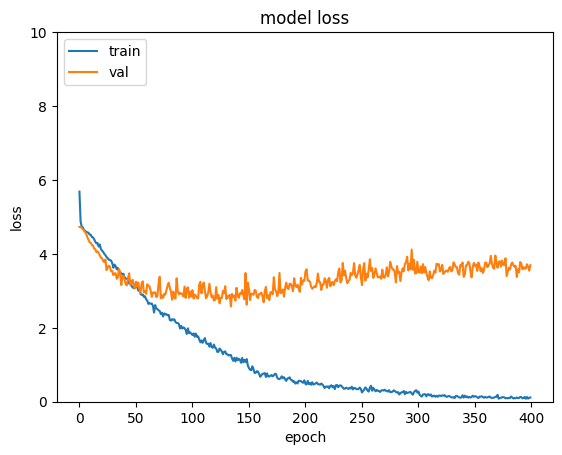

In [29]:
plt.plot(tloss1 + tloss2 + tloss3)
plt.ylim(0,10)
plt.plot(vloss1 + vloss2 + vloss3)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc="upper left")
plt.show()

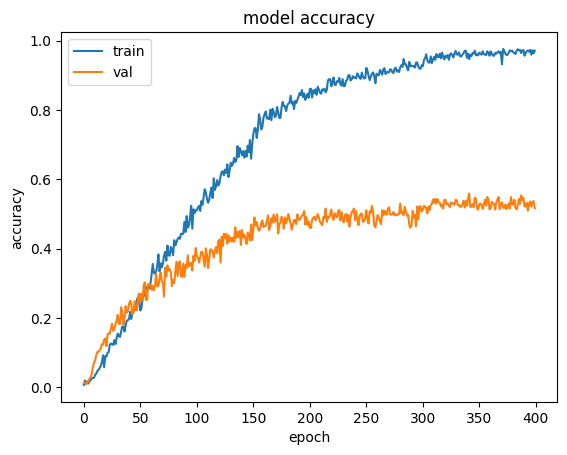

In [30]:
plt.plot(tacc1 + tacc2 + tacc3)
plt.plot(vacc1 + vacc2 + vacc3)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'], loc="upper left")
plt.show()